<center><h2> Sentiment Analysis and Topic Modeling on Youtube Comments</h2></center>

### Import Required Libraries

In [1]:
!pip install unidecode

You should consider upgrading via the 'c:\users\anike\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import re
import nltk
from cleantext import clean
import spacy
from emoticon_fix import emoticon_fix
import emoji
import unidecode

from nltk import pos_tag
from nltk.tokenize import word_tokenize

In [23]:
file_name = 'youtube_comments_MKBHD'
comments_df = pd.read_csv(file_name+'.csv')
comments_df.drop('Unnamed: 0', inplace=True, axis=1)
comments_df.head()

,Video Number,Title,Date Published,Views,Likes,Auther,Comment
0,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Krishnendu Chowdhury,"in a world where $1000 phones are now normal, ..."
1,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,david davud,"I feel that after this, the next logical step ..."
2,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Mathew Blanc,"I'm still on my Pixel 2, it was a surprise to ..."
3,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Jacob Olness,"Like you said, I think it is smart they're for..."
4,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Thanos The Mad Titan,High refresh rate mid rangers and budget phone...


In [24]:
comments_df.shape

(10290, 7)

So this dataset contains only 228 comments with 6 other columns representing video details.

In [25]:
comments_df.columns

Index(['Video Number', 'Title', 'Date Published', 'Views', 'Likes', 'Auther',
       'Comment'],
      dtype='object')

* `Video Number` - Serial number for videos.
* `Title` - Title of the Youtube video.
* `Date Published` - Date when the video was uploaded.
* `Views` - Number of views for that video.
* `Likes` - Number of likes on that video.
* `Author` - Name of the user who posted the comment.
* `Comment` - Comment on the video.

In [26]:
comments_df.describe()

,Video Number,Views,Likes
count,10290.000000,1.029000e+04,10290.000000
mean,127.132459,5.174259e+06,197912.256463
std,38.922448,2.580523e+06,85189.988329
min,1.000000,7.289810e+05,186.000000
25%,133.000000,2.586728e+06,115586.000000
50%,144.000000,4.511416e+06,184387.000000
75%,149.000000,7.744762e+06,282676.000000
max,171.000000,1.375456e+07,581996.000000


In [27]:
comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10290 entries, 0 to 10289
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Video Number    10290 non-null  int64 
 1   Title           10290 non-null  object
 2   Date Published  10290 non-null  object
 3   Views           10290 non-null  int64 
 4   Likes           10290 non-null  int64 
 5   Auther          9748 non-null   object
 6   Comment         10117 non-null  object
dtypes: int64(3), object(4)
memory usage: 562.9+ KB


We'll drop the rows where comment is null.

In [28]:
comments_df.dropna(axis=0, inplace=True)

In [29]:
comments_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9744 entries, 0 to 10120
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Video Number    9744 non-null   int64 
 1   Title           9744 non-null   object
 2   Date Published  9744 non-null   object
 3   Views           9744 non-null   int64 
 4   Likes           9744 non-null   int64 
 5   Auther          9744 non-null   object
 6   Comment         9744 non-null   object
dtypes: int64(3), object(4)
memory usage: 609.0+ KB


### Converting emojis and emoticons to text

**Before removing emoticons**

In [30]:
comments_df.iloc[401]['Comment']

"This really reminds me of SGI back in the day. Silicon Graphics were these beatiful computers, great design and powerful too - but most people had zero use for it. Back then, I was thinking about getting into 3D graphics - just to work with something this beatiful and outlandish. I'm too old to start a video editing studio now to have a nice aluminum box :-) My Ryzen with Nvidia GPU is pretty much equal to this and when I'm done with my workstation, kids gonna get it for games or it's gonna be my new home server."

In [31]:
comments_df['Cleaned_Comments'] = comments_df['Comment'].apply(emoticon_fix.emoticon_fix)

**After removing emoticons**

In [32]:
comments_df.iloc[401]['Cleaned_Comments']

"This really reminds me of SGI back in the day . Silicon Graphics were these beatiful computers , great design and powerful too - but most people had zero use for it . Back then , I was thinking about getting into 3D graphics - just to work with something this beatiful and outlandish . I'm too old to start a video editing studio now to have a nice aluminum box Smile My Ryzen with Nvidia GPU is pretty much equal to this and when I'm done with my workstation , kids gonna get it for games or it's gonna be my new home server ."

**Before removing emojis**

In [33]:
comments_df.iloc[50]['Comment']

'"The hit hits so hard". \n\nYou can clearly tell how deeply he\'s impressed by the device 😁.'

In [34]:
comments_df['Cleaned_Comments'] = comments_df['Cleaned_Comments'].apply(emoji.demojize)

**After removing emojis**

In [35]:
comments_df.iloc[50]['Cleaned_Comments']

'" The hit hits so hard " . You can clearly tell how deeply he\'s impressed by the device :beaming_face_with_smiling_eyes: .'

### Text processing and cleaning:

This function removes emojis, symbols such as `'?'`, `'/'`, `'.'`, `','` and short-forms present in the comments.

In [36]:
comments_df.iloc[0]['Comment']

'in a world where $1000 phones are now normal, it’s refreshing to see a mid tier phone with so much attention to detail.. I am definitely not expecting it to outshine a $1000 phone, that’d be unrealistic, just need a clean experience.'

In [37]:
def clean_comments(text):
    "takes text in raw format and returns clean text with only words and letters. "
    
    text = text.lower()
    text = clean(text, no_emoji=True)
    
    text = re.sub(r"it'll", "it will", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"i'll", "i will", text)
    text = re.sub(r"i've", "i have", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"i'd", "i did", text)
    text = re.sub(r"that'd", "that would", text)
    text = re.sub(r"couldn't", "could not", text)
    
    text = re.sub(r"_", " ", text)
    text = re.sub(r"[0-9]+", "", text)
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    text = re.sub(r'[-"?$+:&%!.(),@>]', "", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"'s", "", text)
    
    text = unidecode.unidecode(text)

    text = text.strip()
    
    return text

In [38]:
comments_df['Cleaned_Comments'] = comments_df['Cleaned_Comments'].apply(clean_comments)

In [39]:
comments_df.iloc[50]['Cleaned_Comments']

'the hit hits so hard   you can clearly tell how deeply hes impressed by the device beaming face with smiling eyes'

In [40]:
# comments_df.to_csv('H.csv', index=False)

In [41]:
comments_df.head(2)

,Video Number,Title,Date Published,Views,Likes,Auther,Comment,Cleaned_Comments
0,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Krishnendu Chowdhury,"in a world where $1000 phones are now normal, ...",in a world where phones are now normal it ...
1,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,david davud,"I feel that after this, the next logical step ...",i feel that after this the next logical step ...


### Removing Stopwords

In [42]:
from nltk.corpus import stopwords, wordnet
stop_words = stopwords.words('english')

In [43]:
def remove_stopwords(text):
    
    new_text = []
    for i in text.split(' '):
        
        if i not in stop_words:
            str(new_text.append(i))
            new_text.append(' ')
        else:
            pass
            
    text = ''.join(new_text)
    
    return text.strip()

In [44]:
comments_df['Cleaned_Comments'] = comments_df['Cleaned_Comments'].apply(remove_stopwords)

In [45]:
comments_df['Cleaned_Comments']

0        world   phones normal   refreshing see mid tie...
1        feel  next logical step smart watch  rely much...
2        still pixel   surprise hear coloured notificat...
3        like said  think smart forging path products  ...
4        high refresh rate mid rangers budget phones fa...
                               ...                        
10116    appreciate man  reviews extremely helpful cut ...
10117    currently run pixel  xl  really love many feat...
10118    wish released premium xl variant telephoto dep...
10119                    flagship  flagship  practicalship
10120    looking forward full review  already ordered p...
Name: Cleaned_Comments, Length: 9744, dtype: object

Now you can see after applying the `remove_stopwords()` function we don't have any stopword in the comment texts.

### Tokenization

In [46]:
comments_df['Tokenized'] = comments_df['Cleaned_Comments'].apply(word_tokenize)

In [47]:
comments_df['Tokenized']

0        [world, phones, normal, refreshing, see, mid, ...
1        [feel, next, logical, step, smart, watch, rely...
2        [still, pixel, surprise, hear, coloured, notif...
3        [like, said, think, smart, forging, path, prod...
4        [high, refresh, rate, mid, rangers, budget, ph...
                               ...                        
10116    [appreciate, man, reviews, extremely, helpful,...
10117    [currently, run, pixel, xl, really, love, many...
10118    [wish, released, premium, xl, variant, telepho...
10119                  [flagship, flagship, practicalship]
10120    [looking, forward, full, review, already, orde...
Name: Tokenized, Length: 9744, dtype: object

### POS tagging

In [48]:
comments_df['POS_tag'] = comments_df['Tokenized'].apply(pos_tag)

In [49]:
comments_df.head()

,Video Number,Title,Date Published,Views,Likes,Auther,Comment,Cleaned_Comments,Tokenized,POS_tag
0,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Krishnendu Chowdhury,"in a world where $1000 phones are now normal, ...",world phones normal refreshing see mid tie...,"[world, phones, normal, refreshing, see, mid, ...","[(world, NN), (phones, NNS), (normal, JJ), (re..."
1,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,david davud,"I feel that after this, the next logical step ...",feel next logical step smart watch rely much...,"[feel, next, logical, step, smart, watch, rely...","[(feel, VB), (next, JJ), (logical, JJ), (step,..."
2,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Mathew Blanc,"I'm still on my Pixel 2, it was a surprise to ...",still pixel surprise hear coloured notificat...,"[still, pixel, surprise, hear, coloured, notif...","[(still, RB), (pixel, JJ), (surprise, NN), (he..."
3,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Jacob Olness,"Like you said, I think it is smart they're for...",like said think smart forging path products ...,"[like, said, think, smart, forging, path, prod...","[(like, IN), (said, VBD), (think, VBP), (smart..."
4,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Thanos The Mad Titan,High refresh rate mid rangers and budget phone...,high refresh rate mid rangers budget phones fa...,"[high, refresh, rate, mid, rangers, budget, ph...","[(high, JJ), (refresh, NN), (rate, NN), (mid, ..."


### Lemmatization

Lemmatization is the process of reducing the words to its base word. For example the base word for looks, looking, looked is look.

In [50]:
# text_list = comments_df['Cleaned_Comments'].tolist()
# len(text_list)

In [51]:
# nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ']): 
#     output = []
#     for sent in texts:
#         doc = nlp(sent) 
#         output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
#     return output

In [52]:
# lemmatized_words = lemmatization(text_list)

In [53]:
# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(tags):
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

In [54]:
comments_df['POS_tag'] = comments_df['POS_tag'].apply(token_stop_pos)
comments_df.head(3)

,Video Number,Title,Date Published,Views,Likes,Auther,Comment,Cleaned_Comments,Tokenized,POS_tag
0,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Krishnendu Chowdhury,"in a world where $1000 phones are now normal, ...",world phones normal refreshing see mid tie...,"[world, phones, normal, refreshing, see, mid, ...","[(world, n), (phones, n), (normal, a), (refres..."
1,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,david davud,"I feel that after this, the next logical step ...",feel next logical step smart watch rely much...,"[feel, next, logical, step, smart, watch, rely...","[(feel, v), (next, a), (logical, a), (step, n)..."
2,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Mathew Blanc,"I'm still on my Pixel 2, it was a surprise to ...",still pixel surprise hear coloured notificat...,"[still, pixel, surprise, hear, coloured, notif...","[(still, r), (pixel, a), (surprise, n), (hear,..."


In [55]:
from nltk.stem import WordNetLemmatizer
wordnetlemma = WordNetLemmatizer()

def lemmatization(pos_tag):
    lemma_rew = ""
    for word, pos in pos_tag:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnetlemma.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    
    return lemma_rew.strip().split(' ')    

In [56]:
comments_df['Lemmatized'] = comments_df['POS_tag'].apply(lemmatization)

In [57]:
comments_df.head()

,Video Number,Title,Date Published,Views,Likes,Auther,Comment,Cleaned_Comments,Tokenized,POS_tag,Lemmatized
0,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Krishnendu Chowdhury,"in a world where $1000 phones are now normal, ...",world phones normal refreshing see mid tie...,"[world, phones, normal, refreshing, see, mid, ...","[(world, n), (phones, n), (normal, a), (refres...","[world, phone, normal, refresh, see, mid, tier..."
1,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,david davud,"I feel that after this, the next logical step ...",feel next logical step smart watch rely much...,"[feel, next, logical, step, smart, watch, rely...","[(feel, v), (next, a), (logical, a), (step, n)...","[feel, next, logical, step, smart, watch, rely..."
2,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Mathew Blanc,"I'm still on my Pixel 2, it was a surprise to ...",still pixel surprise hear coloured notificat...,"[still, pixel, surprise, hear, coloured, notif...","[(still, r), (pixel, a), (surprise, n), (hear,...","[still, pixel, surprise, hear, colour, notific..."
3,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Jacob Olness,"Like you said, I think it is smart they're for...",like said think smart forging path products ...,"[like, said, think, smart, forging, path, prod...","[(like, None), (said, v), (think, v), (smart, ...","[like, say, think, smart, forge, path, product..."
4,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Thanos The Mad Titan,High refresh rate mid rangers and budget phone...,high refresh rate mid rangers budget phones fa...,"[high, refresh, rate, mid, rangers, budget, ph...","[(high, a), (refresh, n), (rate, n), (mid, a),...","[high, refresh, rate, mid, ranger, budget, pho..."


Finding total length of lemmatized words for calculating Sentiment score.

In [58]:
def cal_len(lemmatized):
    return len(lemmatized)

comments_df['Length'] = comments_df['Lemmatized'].apply(cal_len)
comments_df.head()

,Video Number,Title,Date Published,Views,Likes,Auther,Comment,Cleaned_Comments,Tokenized,POS_tag,Lemmatized,Length
0,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Krishnendu Chowdhury,"in a world where $1000 phones are now normal, ...",world phones normal refreshing see mid tie...,"[world, phones, normal, refreshing, see, mid, ...","[(world, n), (phones, n), (normal, a), (refres...","[world, phone, normal, refresh, see, mid, tier...",19
1,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,david davud,"I feel that after this, the next logical step ...",feel next logical step smart watch rely much...,"[feel, next, logical, step, smart, watch, rely...","[(feel, v), (next, a), (logical, a), (step, n)...","[feel, next, logical, step, smart, watch, rely...",14
2,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Mathew Blanc,"I'm still on my Pixel 2, it was a surprise to ...",still pixel surprise hear coloured notificat...,"[still, pixel, surprise, hear, coloured, notif...","[(still, r), (pixel, a), (surprise, n), (hear,...","[still, pixel, surprise, hear, colour, notific...",24
3,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Jacob Olness,"Like you said, I think it is smart they're for...",like said think smart forging path products ...,"[like, said, think, smart, forging, path, prod...","[(like, None), (said, v), (think, v), (smart, ...","[like, say, think, smart, forge, path, product...",29
4,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Thanos The Mad Titan,High refresh rate mid rangers and budget phone...,high refresh rate mid rangers budget phones fa...,"[high, refresh, rate, mid, rangers, budget, ph...","[(high, a), (refresh, n), (rate, n), (mid, a),...","[high, refresh, rate, mid, ranger, budget, pho...",15


**Before and After Lemmatization**

In [59]:
index = 5

print(f'Before: \n{comments_df.iloc[index]["Tokenized"]}')

# text_list_lemma = comments_df['Comment'].tolist()
print(f'\nAfter: \n{comments_df.iloc[index]["Lemmatized"]}')

Before: 
['notification', 'led', 'cool', 'feature', 'miss', 'old', 'xperia', 'ion', 'companies', 'add', 'back', 'least', 'using', 'always', 'display', 'like', 'ppl', 'turn', 'aod', 'save', 'battery', 'little', 'circular', 'blinking', 'dot', 'corner', 'preferably', 'could', 'choose', 'location', 'screen', 'would', 'job', 'perfectly']

After: 
['notification', 'lead', 'cool', 'feature', 'miss', 'old', 'xperia', 'ion', 'company', 'add', 'back', 'least', 'use', 'always', 'display', 'like', 'ppl', 'turn', 'aod', 'save', 'battery', 'little', 'circular', 'blink', 'dot', 'corner', 'preferably', 'could', 'choose', 'location', 'screen', 'would', 'job', 'perfectly']


Reading words from database of `positive` and `negative` words.

In [60]:
file1 = open('positive-words.txt', 'r')
pos_words = file1.read().split()

file2 = open('negative-words.txt', 'r')
neg_words = file2.read().split()

In [61]:
print('\n------------------------\nFew sample words:\n------------------------\nPositive Words\n------------------------\n')
for i in range(5):
    print(pos_words[i])

print('\n------------------------\nNegative Words\n------------------------\n')
for i in range(5):
    print(neg_words[i])


------------------------
Few sample words:
------------------------
Positive Words
------------------------

a+
abound
abounds
abundance
abundant

------------------------
Negative Words
------------------------

2-faced
2-faces
abnormal
abolish
abominable


In [62]:
def count_pos(text):
    
    count = 0
    for i in text:
        if i in pos_words:
            count += 1
            
    return count

def count_neg(text):
    
    count = 0
    for i in text:
        if i in neg_words:
            count += 1
            
    return count

In [63]:
comments_df['Positive count'] = comments_df['Lemmatized'].apply(count_pos)
comments_df['Negative count'] = comments_df['Lemmatized'].apply(count_neg)
comments_df.head()

,Video Number,Title,Date Published,Views,Likes,Auther,Comment,Cleaned_Comments,Tokenized,POS_tag,Lemmatized,Length,Positive count,Negative count
0,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Krishnendu Chowdhury,"in a world where $1000 phones are now normal, ...",world phones normal refreshing see mid tie...,"[world, phones, normal, refreshing, see, mid, ...","[(world, n), (phones, n), (normal, a), (refres...","[world, phone, normal, refresh, see, mid, tier...",19,3,1
1,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,david davud,"I feel that after this, the next logical step ...",feel next logical step smart watch rely much...,"[feel, next, logical, step, smart, watch, rely...","[(feel, v), (next, a), (logical, a), (step, n)...","[feel, next, logical, step, smart, watch, rely...",14,3,0
2,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Mathew Blanc,"I'm still on my Pixel 2, it was a surprise to ...",still pixel surprise hear coloured notificat...,"[still, pixel, surprise, hear, coloured, notif...","[(still, r), (pixel, a), (surprise, n), (hear,...","[still, pixel, surprise, hear, colour, notific...",24,2,1
3,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Jacob Olness,"Like you said, I think it is smart they're for...",like said think smart forging path products ...,"[like, said, think, smart, forging, path, prod...","[(like, None), (said, v), (think, v), (smart, ...","[like, say, think, smart, forge, path, product...",29,8,1
4,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Thanos The Mad Titan,High refresh rate mid rangers and budget phone...,high refresh rate mid rangers budget phones fa...,"[high, refresh, rate, mid, rangers, budget, ph...","[(high, a), (refresh, n), (rate, n), (mid, a),...","[high, refresh, rate, mid, ranger, budget, pho...",15,4,0


### Calculating the final sentiment score

In [64]:
comments_df['Sentiment'] = round(((comments_df['Positive count'] - comments_df['Negative count']) / comments_df['Length']), 2)
comments_df.head()

,Video Number,Title,Date Published,Views,Likes,Auther,Comment,Cleaned_Comments,Tokenized,POS_tag,Lemmatized,Length,Positive count,Negative count,Sentiment
0,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Krishnendu Chowdhury,"in a world where $1000 phones are now normal, ...",world phones normal refreshing see mid tie...,"[world, phones, normal, refreshing, see, mid, ...","[(world, n), (phones, n), (normal, a), (refres...","[world, phone, normal, refresh, see, mid, tier...",19,3,1,0.11
1,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,david davud,"I feel that after this, the next logical step ...",feel next logical step smart watch rely much...,"[feel, next, logical, step, smart, watch, rely...","[(feel, v), (next, a), (logical, a), (step, n)...","[feel, next, logical, step, smart, watch, rely...",14,3,0,0.21
2,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Mathew Blanc,"I'm still on my Pixel 2, it was a surprise to ...",still pixel surprise hear coloured notificat...,"[still, pixel, surprise, hear, coloured, notif...","[(still, r), (pixel, a), (surprise, n), (hear,...","[still, pixel, surprise, hear, colour, notific...",24,2,1,0.04
3,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Jacob Olness,"Like you said, I think it is smart they're for...",like said think smart forging path products ...,"[like, said, think, smart, forging, path, prod...","[(like, None), (said, v), (think, v), (smart, ...","[like, say, think, smart, forge, path, product...",29,8,1,0.24
4,1,Nothing Phone (1) Review: Seeing Through the H...,2022-07-15,2771251,129382,Thanos The Mad Titan,High refresh rate mid rangers and budget phone...,high refresh rate mid rangers budget phones fa...,"[high, refresh, rate, mid, rangers, budget, ph...","[(high, a), (refresh, n), (rate, n), (mid, a),...","[high, refresh, rate, mid, ranger, budget, pho...",15,4,0,0.27


In [65]:
# comments_df.to_csv('Cleaned Comments MKBHD.csv', index=False)

### Top Positive Reviews

In [47]:
comments_df.sort_values(by='Sentiment', ascending=False)[['Cleaned_Comments', 'Lemmatized', 'Positive count', 'Sentiment']]

,Cleaned_Comments,Lemmatized,Positive count,Sentiment
6202,welcome,[welcome],1,1.0
3190,thank helpful,"[thank, helpful]",2,1.0
7828,awesome,[awesome],1,1.0
6287,nice,[nice],1,1.0
4596,thank,[thank],1,1.0
...,...,...,...,...
4684,hate hate,"[hate, hate]",0,-1.0
6339,ugly expensive,"[ugly, expensive]",0,-1.0
4808,loud,[loud],0,-1.0
4284,fucking died,"[fuck, die]",0,-1.0


### Top Negative Reviews

In [48]:
comments_df.sort_values(by='Sentiment', ascending=True)[['Cleaned_Comments', 'Lemmatized', 'Negative count', 'Sentiment']]

,Cleaned_Comments,Lemmatized,Negative count,Sentiment
4284,fucking died,"[fuck, die]",2,-1.0
4684,hate hate,"[hate, hate]",2,-1.0
9064,slow,[slow],1,-1.0
6569,ripoff,[ripoff],1,-1.0
5010,hate,[hate],1,-1.0
...,...,...,...,...
4836,nice,[nice],0,1.0
4828,nice,[nice],0,1.0
9043,nice,[nice],0,1.0
6647,wow,[wow],0,1.0


Let's visualize the most frequent words using wordcloud.

### Positive WordCloud

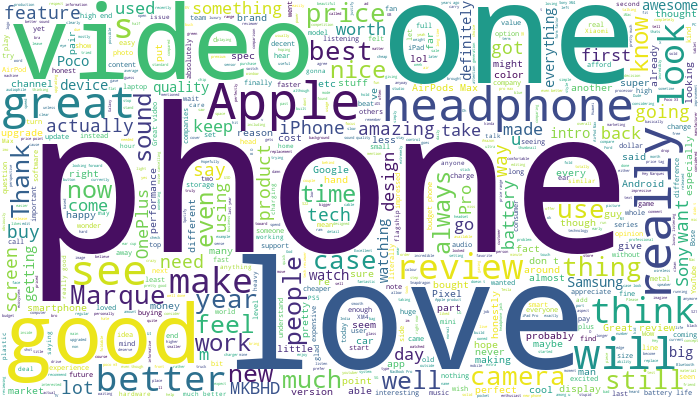

In [49]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white', max_words=1000, contour_width=5, contour_color='steelblue', width=700, height=400)
wordcloud.generate(' '.join(comments_df[comments_df['Sentiment'] > 0.0]['Comment']))
wordcloud.to_image() 

### Negative WordCloud

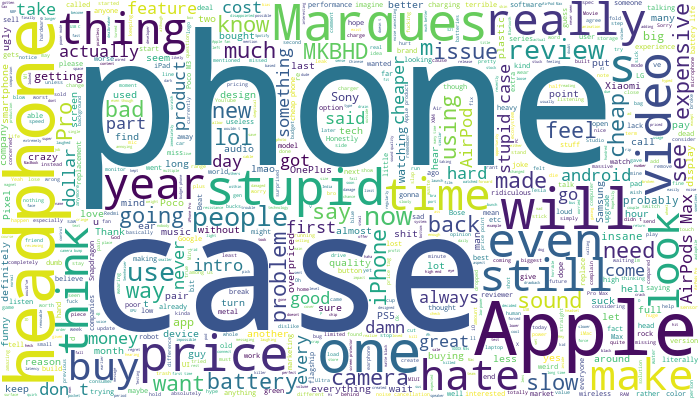

In [50]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white', max_words=1000, contour_width=5, contour_color='steelblue', width=700, height=400)
wordcloud.generate(' '.join(comments_df[comments_df['Sentiment'] < 0.0]['Comment']))
wordcloud.to_image() 

### Building LDA Model

In [ ]:
from gensim import corpora

# Building word dictionary and Document term matrix
dictionary = corpora.Dictionary(lemmatized_words)
doc_term_matrix = [dictionary.doc2bow(i) for i in lemmatized_words]

In [ ]:
from gensim.models.ldamodel import LdaModel

lda_model = LdaModel(corpus=doc_term_matrix,
                     id2word=dictionary,
                     num_topics=5,
                     random_state=10,
                     chunksize=500,
                     passes=10,
                     iterations=100)
lda_model.print_topics()

### Topic Visualization

In [ ]:
import pyLDAvis
from pyLDAvis import gensim_models

pyLDAvis.enable_notebook()
visuals = gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
visuals